In [104]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [105]:
# (Assuming data loading and model training are done as before)
# Load and preprocess data (recap)
data = pd.read_csv("heart_disease.csv")
# Format columns to be object-friendly format
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.head()

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


In [106]:
data.columns

Index(['age', 'gender', 'blood_pressure', 'cholesterol_level',
       'exercise_habits', 'smoking', 'family_heart_disease', 'diabetes', 'bmi',
       'high_blood_pressure', 'low_hdl_cholesterol', 'high_ldl_cholesterol',
       'alcohol_consumption', 'stress_level', 'sleep_hours',
       'sugar_consumption', 'triglyceride_level', 'fasting_blood_sugar',
       'crp_level', 'homocysteine_level', 'heart_disease_status'],
      dtype='object')

## EDA

In [107]:
# Data size
print(f"Data size: {data.shape}")

Data size: (10000, 21)


In [108]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
age                       29
gender                    19
blood_pressure            19
cholesterol_level         30
exercise_habits           25
smoking                   25
family_heart_disease      21
diabetes                  30
bmi                       22
high_blood_pressure       26
low_hdl_cholesterol       25
high_ldl_cholesterol      26
alcohol_consumption     2586
stress_level              22
sleep_hours               25
sugar_consumption         30
triglyceride_level        26
fasting_blood_sugar       22
crp_level                 26
homocysteine_level        20
dtype: int64


Impute missing data using Decision Tree

In [109]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

pd.set_option('future.no_silent_downcasting', True)
def missforest_imputation(df):
    df_imputed = df.copy()
    
    # Dictionary to store label encoders for categorical columns
    label_encoders = {}
    
    # Iterate until all missing values are imputed or max iterations reached
    max_iter = 10
    iter_count = 0
    
    while df_imputed.isnull().sum().sum() > 0 and iter_count < max_iter:
        iter_count += 1
        prev_null_count = df_imputed.isnull().sum().sum()
        print(f"Iteration {iter_count}: {prev_null_count} missing values")
        for column in df_imputed.columns:
            # Skip if no missing values in this column
            if df_imputed[column].isnull().sum() == 0:
                continue
                
            # Create mask for rows where current column is missing
            mask = df_imputed[column].isnull()
            
            # Features for prediction (all except current)
            features = [col for col in df_imputed.columns if col != column]
            
            # Prepare training data
            X_train = df_imputed.loc[~mask, features].copy()
            y_train = df_imputed.loc[~mask, column].copy()
            
            # Prepare prediction data
            X_predict = df_imputed.loc[mask, features].copy()
            
            # Temporarily encode any string features for the model
            for feat in features:
                if pd.api.types.is_object_dtype(df_imputed[feat]):
                    # Create encoder if it doesn't exist for this column
                    if feat not in label_encoders:
                        label_encoders[feat] = LabelEncoder()
                        # Fit on non-null values
                        label_encoders[feat].fit(df_imputed[feat].dropna().astype(str))
                    
                    # Transform non-null values in both training and prediction sets
                    X_train.loc[X_train[feat].notna(), feat] = label_encoders[feat].transform(
                        X_train.loc[X_train[feat].notna(), feat].astype(str))
                    X_predict.loc[X_predict[feat].notna(), feat] = label_encoders[feat].transform(
                        X_predict.loc[X_predict[feat].notna(), feat].astype(str))
            
            # Fill remaining NAs with mean or mode - Fixed downcasting warning
            for feat in features:
                if pd.api.types.is_numeric_dtype(df_imputed[feat]):
                    fill_value = X_train[feat].mean()
                else:
                    fill_value = X_train[feat].mode()[0]
                
                # Add infer_objects to handle downcasting explicitly
                X_train[feat] = X_train[feat].fillna(fill_value).infer_objects(copy=False)
                X_predict[feat] = X_predict[feat].fillna(fill_value).infer_objects(copy=False)
            
            # Choose estimator based on data type
            if pd.api.types.is_numeric_dtype(df_imputed[column]):
                estimator = RandomForestRegressor(n_estimators=100, random_state=42)
                estimator.fit(X_train, y_train)
                predicted_values = estimator.predict(X_predict)
            else:
                # For categorical columns, encode target values
                if column not in label_encoders:
                    label_encoders[column] = LabelEncoder()
                    label_encoders[column].fit(df_imputed[column].dropna().astype(str))
                
                # Transform training data
                y_train_encoded = label_encoders[column].transform(y_train.astype(str))
                
                # Train classifier
                estimator = RandomForestClassifier(n_estimators=100, random_state=42)
                estimator.fit(X_train, y_train_encoded)
                
                # Predict and inverse transform back to original categories
                predicted_indices = estimator.predict(X_predict)
                predicted_values = label_encoders[column].inverse_transform(predicted_indices)
                
            # Fill in the missing values
            df_imputed.loc[mask, column] = predicted_values
        
        # Check if we're making progress
        current_null_count = df_imputed.isnull().sum().sum()
        print(f"Iteration {iter_count}: {current_null_count} missing values remaining")
        if current_null_count == prev_null_count:
            print("No progress made, stopping early.")
            break
    
    return df_imputed

# Check for imputed saved data
try:
    imputed_data = pd.read_csv("imputed_heart_disease.csv")
except FileNotFoundError:
    # Usage
    imputed_data = missforest_imputation(data)
    # Check for missing values
    missing_values_after = imputed_data.isnull().sum()
    print("Missing values after imputation:")
    print(missing_values_after[missing_values_after > 0])

In [110]:
imputed_data.head()

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,126.46,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.00,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.00,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.00,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.00,10.381259,8.153887,No


In [111]:
imputed_data.to_csv("imputed_heart_disease.csv", index=False)

In [112]:
# Split the data into features and target
X = imputed_data.drop(columns=["heart_disease_status"])
y = imputed_data["heart_disease_status"]
# Encode categorical variables
le = LabelEncoder()
y = le.fit_transform(y)

In [113]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (8000, 20), Testing set size: (2000, 20)


In [114]:
# Build the preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Separate regular categorical from ordinal columns
ordinal_cols = [col.lower().replace(" ", "_") for col in ['Exercise Habits', 'Alcohol Consumption', 'Sugar Consumption']]
# Get remaining categorical columns (excluding ordinal ones)
regular_categorical_cols = [col for col in X.select_dtypes(include=['object']).columns 
                           if col not in ordinal_cols]
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Ordinal columns: {ordinal_cols}")
print(f"Regular categorical columns: {regular_categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Define ordinal categories with their order
ordinal_categories = [['Low', 'Medium', 'High'] for _ in range(len(ordinal_cols))]


Ordinal columns: ['exercise_habits', 'alcohol_consumption', 'sugar_consumption']
Regular categorical columns: ['gender', 'smoking', 'family_heart_disease', 'diabetes', 'high_blood_pressure', 'low_hdl_cholesterol', 'high_ldl_cholesterol', 'stress_level']
Numerical columns: ['age', 'blood_pressure', 'cholesterol_level', 'bmi', 'sleep_hours', 'triglyceride_level', 'fasting_blood_sugar', 'crp_level', 'homocysteine_level']


In [115]:

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
])

categorial_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories))
])

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numerical_cols),
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorial_transformer, regular_categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ],
    remainder='drop'
)

xgb_model = xgb.XGBClassifier(
    eval_metric="logloss", 
    use_label_encoder=False, random_state=42
)

# Create a pipeline with preprocessing, PCA, and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Fit the model
pipeline.fit(X_train, y_train)

/home/aphuc/ai/workspace/xdoc/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:22:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['age', 'blood_pressure',
                                                   'cholesterol_level', 'bmi',
                                                   'sleep_hours',
                                                   'triglyceride_level',
                                                   'fasting_blood_sugar',
                                                   'crp_level',
                                                   'homocysteine_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEn...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [116]:
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

model = pipeline.named_steps['model']
# Get feature names after preprocessing
predictions = model.predict(X_test_transformed)
# Test accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7880


In [117]:
# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)
print(f"SHAP values shape: {shap_values.shape}")  # Confirm (n_samples, n_features)

SHAP values shape: (2000, 29)


In [118]:
# Select single patient
single_patient = X_test[0:1].copy()  # Select the first patient
# Transform the single patient data using the preprocessing pipeline
print(type(single_patient))
single_patient

<class 'pandas.core.frame.DataFrame'>


,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,low_hdl_cholesterol,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level
6252,38.0,Male,169.0,156.0,Medium,Yes,No,Yes,35.303549,No,No,Yes,Medium,High,4.213721,Medium,321.0,158.0,9.778347,17.400056


(1, 29)
SHAP values for single patient shape: (1, 29)


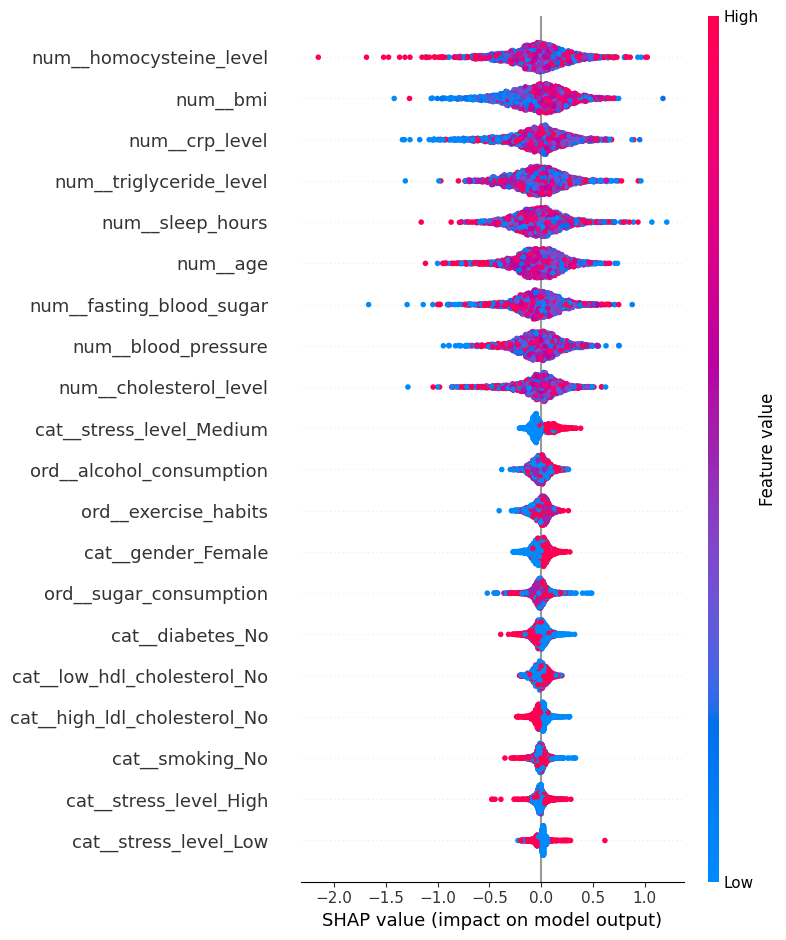

In [119]:
# Transform the single patient data using the preprocessing pipeline
single_patient_transformed = pipeline.named_steps['preprocessor'].transform(single_patient)
print(single_patient_transformed.shape)  # Confirm (1, n_features)
# Compute SHAP values for the single patient
shap_values_single = explainer.shap_values(single_patient_transformed)
print(f"SHAP values for single patient shape: {shap_values_single.shape}")  # Confirm (1, n_features)
# shap.plots.waterfall(shap_values_single[0], max_display=10, show=True)
# Plot summary of SHAP values for the test set
shap.summary_plot(shap_values, X_test_transformed, feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(), show=True)

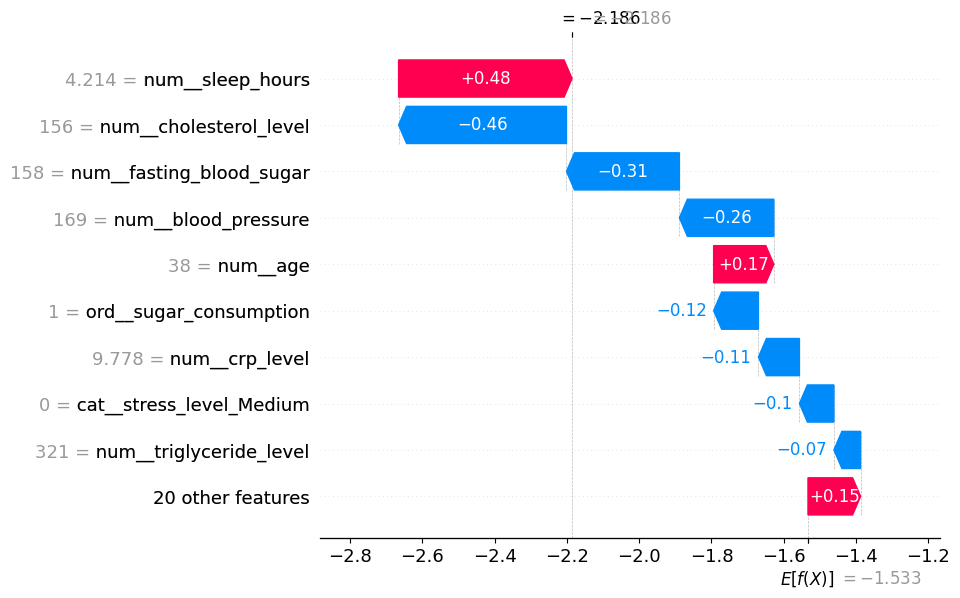

In [120]:
import matplotlib.pyplot as plt

# Set the plot width
plt.figure(figsize=(24, 6))  # Adjust the width (12) and height (6) as needed

# Get feature names from the preprocessing pipeline
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create SHAP explanation object (expected by force_plot)
shap_explanation = shap.Explanation(
    values=shap_values_single[0],
    base_values=explainer.expected_value,
    data=single_patient_transformed[0],
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation, max_display=10)

In [127]:
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values[0]

explanation = []
features = X_train.iloc[0].to_dict()  # Get the first row as a dictionary
for i, (name, value) in enumerate(features.items()):
    explanation.append({
        "feature": name,
        "value": value,
        "shap_value": float(shap_vals[i])  # Corrected to use `i` directly
    })
explanation

[{'feature': 'age', 'value': 78.0, 'shap_value': 0.1665748804807663},
 {'feature': 'gender', 'value': 'Male', 'shap_value': -0.2612851560115814},
 {'feature': 'blood_pressure',
  'value': 140.0,
  'shap_value': -0.4645541310310364},
 {'feature': 'cholesterol_level',
  'value': 289.0,
  'shap_value': 0.03701021522283554},
 {'feature': 'exercise_habits',
  'value': 'High',
  'shap_value': 0.4800510108470917},
 {'feature': 'smoking', 'value': 'Yes', 'shap_value': -0.07383795827627182},
 {'feature': 'family_heart_disease',
  'value': 'Yes',
  'shap_value': -0.312493234872818},
 {'feature': 'diabetes', 'value': 'No', 'shap_value': -0.113410085439682},
 {'feature': 'bmi',
  'value': 25.086206257342685,
  'shap_value': -0.0023491003084927797},
 {'feature': 'high_blood_pressure',
  'value': 'Yes',
  'shap_value': 0.007745490409433842},
 {'feature': 'low_hdl_cholesterol', 'value': 'Yes', 'shap_value': 0.0},
 {'feature': 'high_ldl_cholesterol',
  'value': 'No',
  'shap_value': -0.012348728254437

In [121]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
load_dotenv("key.env")

def generate(prompt):
    key = os.environ.get("GEMINI_API_KEY")
    if key is None:
        raise ValueError("Please set the GEMINI_API_KEY environment variable")
    client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

    model = "gemini-2.0-flash"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        temperature=0.1,
        top_p=0.95,
        top_k=40,
        max_output_tokens=8192,
        response_mime_type="text/plain",
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")

In [122]:
# Create prompt
prompt = f"""
You are a medical assistant. Interpret the following SHAP values used to predict diabetes. Focus on features with the highest contributions (positive or negative).

Features:
- Glucose: 140 (SHAP: +0.50)
- BMI: 33.2 (SHAP: +0.15)
- Age: 45 (SHAP: -0.02)

Predicted risk: 0.85

Explain to the patient the significance of these features and their SHAP values in relation to their diabetes risk. Use simple language and provide a clear understanding of how these factors contribute to the prediction. Avoid technical jargon and ensure the explanation is patient-friendly.
"""

# Generate explanation
generate(prompt)

Okay, let's talk about your diabetes risk prediction. The system estimates your risk to be 0.85, which is quite high. We used some of your information to arrive at this number, and I want to explain what contributed the most.

Think of it like this: we're building a case for or against you having diabetes based on your information.

*   **Glucose (140, SHAP: +0.50):** Your glucose level is a big factor pushing the prediction *towards* a higher risk. The value is 140, which is above the normal range. The SHAP value of +0.50 means it significantly increases the likelihood of diabetes according to the model. In simple terms, the higher your glucose, the stronger the evidence suggests you might have diabetes.

*   **BMI (33.2, SHAP: +0.15):** Your BMI, which is a measure of body fat based on your height and weight, also contributes to a higher risk, but not as much as your glucose. The SHAP value of +0.15 means it adds to the likelihood of diabetes, but to a lesser extent. A BMI of 33.2 fa

In [123]:
import joblib

joblib.dump(pipeline, "heart_disease_model.pkl")
# Load the model
loaded_pipeline = joblib.load("heart_disease_model.pkl")
# Verify the loaded model
print(loaded_pipeline)
# Make predictions with the loaded model
predictions_loaded = loaded_pipeline.predict(X_test)
# Test accuracy
accuracy_loaded = accuracy_score(y_test, predictions_loaded)
print(f"Accuracy with loaded model: {accuracy_loaded:.4f}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['age', 'blood_pressure',
                                                   'cholesterol_level', 'bmi',
                                                   'sleep_hours',
                                                   'triglyceride_level',
                                                   'fasting_blood_sugar',
                                                   'crp_level',
                                                   'homocysteine_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')

In [124]:
loaded_pipeline.named_steps["model"]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)